In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### 과제1_0518.
타이타닉 데이터 셋에 대하여 필요한 전처리를 수행한 후 랜덤포레스트 알고리즘을 적용하여 평가 및 성능 개선을 수행하시오.

In [43]:
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 15: cat = 'Child'
    elif age <= 20: cat = 'Teenager'
    elif age <= 30: cat = 'Twenties'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 50: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat
def Fare_Cat(fare):
    cat = ''
    if fare <= -1: cat = 'Unknown'
    elif fare <= 8: cat = 'Very Low'
    elif fare <= 11: cat = 'Low'
    elif fare <= 25: cat = 'Middle'
    elif fare <= 50: cat = 'High'
    elif fare <= 100: cat = 'Very High'
    else : cat = 'Extra High'
    
    return cat
def transform_features(df):
    df.dropna(axis = 1, thresh = len(titanic_df)/2, inplace = True)
    
    big = df["Embarked"].value_counts().idxmax()
    df["Embarked"].fillna(big, inplace = True)
    
    pattern = r", (.*?)\."
    df["Title"] = df["Name"].apply(lambda x: re.search(pattern, x).group(1))
    
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(round(x.mean(),0)))
    
    df.drop(['Name', "Ticket", "PassengerId", "SibSp", "Parch", "Embarked"], axis=1, inplace=True)
    
    df["Age_cat"] = df['Age'].apply(lambda x : get_category(x))
    
    df["Fare_cat"] = df['Fare'].apply(lambda x : Fare_Cat(x))
    
    df.drop(["Age", "Fare", "Age_cat"] , axis=1, inplace=True)
    
    features = ["Pclass", "Sex", "Title" , "Fare_cat"]
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

In [44]:
titanic_df = pd.read_csv("../dataSet/train.csv")
y_titanic = titanic_df["Survived"]
X_titanic= titanic_df.drop('Survived',axis=1)

X_titanic = transform_features(X_titanic)

In [45]:
X_train, X_test, y_train, y_test=train_test_split(X_titanic, y_titanic, \
                                                  test_size=0.2, random_state=11)

rf_model = RandomForestClassifier(n_estimators= 100, random_state=11)

In [46]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

In [6]:
def get_clf_eval(y_test = None, pred = None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = round(accuracy_score(y_test, pred),4)
    precision = round(precision_score(y_test, pred),4)
    recall = round(recall_score(y_test, pred),4)
    f1 = round(f1_score(y_test, pred),4)
    roc_auc = round(roc_auc_score(y_test, pred_proba[:, 1]),4)
    print("오차 행렬")
    print(confusion)
    print(f"정확도 : {accuracy}, 정밀도 : {precision}\n재현율 : {recall}, f1 : {f1}")
    print(f"AUC : {roc_auc}")

In [47]:
get_clf_eval(y_test, rf_pred, rf_pred_proba)

오차 행렬
[[109   9]
 [ 17  44]]
정확도 : 0.8547, 정밀도 : 0.8302
재현율 : 0.7213, f1 : 0.7719
AUC : 0.8934


In [52]:
params = {
    "n_estimators" : [50, 100, 200, 300],
    "max_depth" : [2,4,6,8],
    "min_samples_leaf" : [2,6,8,10,12,18],
    "min_samples_split" : [2,4,8,12,16]
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print("최적 하이퍼 파라미터 : \n", grid_cv.best_params_)
print(f"최고 예측 정확도 : {grid_cv.best_score_ : .4f}")

최적 하이퍼 파라미터 : 
 {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 50}
최고 예측 정확도 :  0.8287


In [49]:
X_train, X_test, y_train, y_test=train_test_split(X_titanic, y_titanic, \
                                                  test_size=0.2, random_state=11)

rf_model = RandomForestClassifier(max_depth= 8, min_samples_leaf= 2, min_samples_split= 12, n_estimators= 50, random_state=11)

In [50]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

In [51]:
get_clf_eval(y_test, rf_pred, rf_pred_proba)

오차 행렬
[[110   8]
 [ 15  46]]
정확도 : 0.8715, 정밀도 : 0.8519
재현율 : 0.7541, f1 : 0.8
AUC : 0.9143


### 과제2_0518
과제1로부터 변수 중요도를 도출하고 시각화를 수행하시오.

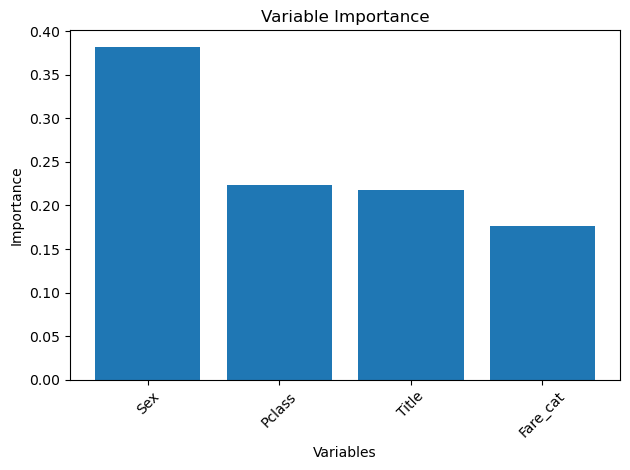

In [48]:
importances = rf_model.feature_importances_

# 중요도 기준으로 변수 순서 정렬
indices = np.argsort(importances)[::-1]

# 변수명 배열
feature_names = X_titanic.columns

# 변수 중요도 시각화
plt.figure()
plt.title("Variable Importance")
plt.bar(range(X_titanic.shape[1]), importances[indices], align="center")
plt.xticks(range(X_titanic.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()